<a href="https://colab.research.google.com/github/dianakang/DIANA_TimeSeries/blob/master/%5B%EC%9D%B4%EA%B2%83%EC%9D%B4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D%EC%9D%B4%EB%8B%A4%5D_CH3_%EB%B9%84%ED%8A%B8%EC%BD%94%EC%9D%B8_%EC%8B%9C%EC%84%B8_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 비트코인 시세 예측하기

비트코인 시세처럼 연속적인 시간에 따라 다르게 측정되는 데이터를 **시계열 데이터**라하며, 이를 분석하는 것을 '시계열 데이터 분석'이라고 한다.

시계열 데이터 분석은 심장 박동 데이터처럼 규칙적 시계열 데이터를 분석하는 것과 비트코인 시세예측처럼 불규칙적 시계열 데이터를 분석하는 것으로 구분할 수 있다.



*   분석 미리보기

: 1년간의 비트코인 데이터를 기반으로 향후 5일간 비트코인 데이터의 시세 변화를 미리 예측한다.


---




*   탐색 - 시간 정보가 포함된 데이터 살펴보기

: 데이터셋을 살펴보면, 비트코인 데이터는 총 365개의 행으로 이루어져 있다는 것을 알 수 있다. 또한 데이터는 결측값 없이 날짜와 가격에 대한 2개의 피처로 구성되어 있다. 이러한 데이터셋을 **시계열 데이터셋**이라고 한다.





## 1.1. 탐색 - 시간 정보가 포함된 데이터 살펴보기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = '/content/drive/MyDrive/Timeseries/blockchain/market-price.csv'
bitcoin_df = pd.read_csv(file_path, names=['day','price'])

print(bitcoin_df.shape)
print(bitcoin_df.info())
bitcoin_df.tail()

(365, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


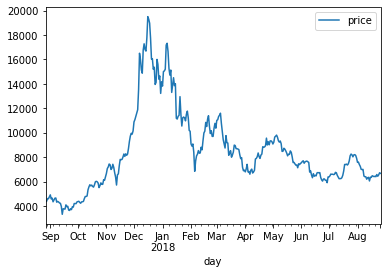

In [2]:
## day 컬럼의 데이터 형태가 object(문자열)이기 때문에 datetime 형태로 바꿔줌
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])

## day 칼럼을 index로 설정
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)

## 일자별 비트코인 시세 시각화
bitcoin_df.plot()
plt.show()

## 1.2. 예측 - 파이썬 라이브러리를 활용해 시세 예측하기

### 1.2.1. ARIMA 활용

첫번쨰로 사용할 시계열 예측 분석 방법은 **ARIMA** 분석 방법이다.

ARIMA는 전통적인 시계열 예측 방법으로 크게 두 가지 개념을 포함하고 있다.

첫번째는 AR(AutoRegression)모델로 자기 자신의 과거를 정보로 사용하는 개념이다.

이는 '현재의 상태는 이전의 상태를 참고해서 계산된다'는 아이디어를 전제로 한다.

두번째 개념은 MA(Moving Average) 모델로 '이전 항에서의 오차를 이용하여 현재 항의 상태를 추론하겠다'라는 방법이다.

그리고 이 둘을 합친 것을 **ARMA** 모델이라고 하며, 조금 더 나아간 **ARIMA**(Autoregressive Integrated Moving Average)모델은 ARMA 모델에 추세 변동의 경향성(Momentum)까지 반영한 방법이다.

파이썬에서는 statsmodel 모듈로 ARIMA 분석을 수행할 수 있다.

다음 코드는 ARIMA 분석의 실행 과정이다.

ARIMA 클래스에 order=(2,1,2)라고 입력되어진 파라미터는 'AR이 몇 번째 과거까지를 바라보는지에 대한 파라미터(2), 차분(Difference)'에 대한 파라미터(1), MA가 몇 번째 과거까지를 바라보는지에 대한 파라미터(2)'를 의미하는 것이다.

차분이란 현재 상태의 변수에서 바로 전 상태의 변수를 뺴주는 것을 의미하며, 시계열 데이터의 불규칙성을 조금이나마 보정해주는 역할을 한다. 또한 앞서 말한 ARIMA 모델의 경향성을 의미한다.

아래의 실행 결과를 분석한 표를 살펴보면 상수항을 제외한 모든 계수의 p-value가 0.05이하로 유의미한 것으로 나타난다. 이것은 AR과 MA 모두 2로 설정하는 것이 꽤나 의미있는 분석 결과를 도출한다는 것이다.

In [3]:
# ARIMA 모델 활용하기 : 모델 학습
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

## (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델을 학습
model = ARIMA(bitcoin_df.price.values, order=(2,1,2))
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2780.074
Method:                       css-mle   S.D. of innovations            501.536
Date:                Wed, 17 Mar 2021   AIC                           5572.148
Time:                        15:31:09   BIC                           5595.531
Sample:                             1   HQIC                          5581.442
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3951     26.944      0.237      0.813     -46.414      59.204
ar.L1.D.y      0.4496      0.029     15.512      0.000       0.393       0.506
ar.L2.D.y     -0.9622      0.023    -42.314      0.0



*   참고!

: 위의 분석과는 별개로 order 파라미터 p,d,q는 일반적인 가이드라인이 존재한다.

보통 p와 q의 합이 2 미만인 경우, 혹은 p와 q의 곱이 0을 포함한 짝수인 경우가 좋은 파라미터의 조합이라고 알려져 있다.


---

다음으로 ARIMA 모델의 학습 결과를 알아보자. 아래의 실행 결과 중 첫 번째 그래프는 학습한 모델에 학습 데이터셋을 넣었을 떄의 시계열 예측 결과이다. 
plot_predict()라는 함수로 시각화를 자동으로 수행할 수 있다.



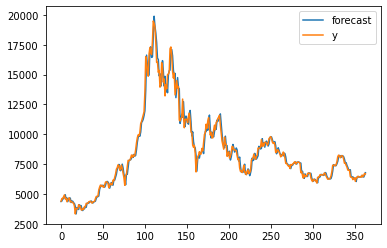

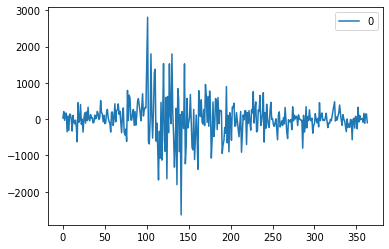

In [4]:
# ARIMA 모델 활용하기 : 모델의 성능 & 예측 결과 시각화
fig = model_fit.plot_predict() ## 학습 데이터에 대한 예측 결과 (첫 번째 그래프)
residuals = pd.DataFrame(model_fit.resid)  ## 잔차의 변동을 시각화 (두 번쨰 그래프)
residuals.plot()

두 번째 그래프는 실제값과 예측값 사이의 오차 변동을 나타내는 그래프이다. 

만약 이 그래프의 폭이 일정하다면 좋은 예측 모델을 학습시킨 것이라고 생각할 수 있다.

하지만 실행 결과에서는 오차 변동이 매우 불안정한 것으로 보인다.

---

다음으로 ARIMA 모델을 평가해보자. 모델을 평가하기 위해서는 테스트 전용 데이터가 필요한데 이번 예제에서는 5일 동안의 미래를 테스트 데이터로 사용하겠다. 

불규칙적 시계열 예측의 경우에는 먼 미래를 예측하는 것이 큰 의미가 없으므로 '앞으로 N일 동안 어느정도로 상승/하락할 것이다' 정도의 대략적인 경향 예측만을 수행하는 것이 일반적이기 때문이다.

---

모델 평가의 과정은 다음과 같다.

1. model_fit.forecast(steps=5)로 향후 5일의 가격을 예측하여 pred_y로 정의한다.

2. '../data/market-price-test.csv'에서 실제 향후 5일의 가격을 test_y로 정의한다.

3. 모델이 예측한 상한값, 하한값을 pred_y_upper, pred_y_lower로 정의한다.

4. 정의한 모든 값을 비교하여 5일 동안의 상승 경향 예측이 얼마나 맞았는지를 평가한다.

In [5]:
# ARIMA 모델 활용하기 : 실제 데이터와의 비교
forecast_data = model_fit.forecast(steps=5)  ## 학습 데이터셋으로부터 5일 뒤를 예측한다.

## 테스트 데이터셋 불러오기
test_file_path = '/content/drive/MyDrive/Timeseries/blockchain/market-price-test.csv'
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds','y'])

pred_y = forecast_data[0].tolist()  ## 마지막 5일의 예측 데이터이다. (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values  ## 실제 5일 가격 데이터이다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = []   ## 마지막 5일의 예측 데이터의 최소값이다.
pred_y_upper = []   ## 마지막 5일의 예측 데이터의 최대값이다.

for lower_upper in forecast_data[2]:
  lower = lower_upper[0]
  upper = lower_upper[1]
  pred_y_lower.append(lower)
  pred_y_upper.append(upper)

다음 코드는 이를 그래프로 시각화한것이다. 파란색 그래프는 모델이 예상한 최고 가격, 즉 상한가의 그래프이다.

그리고 빨간색은 모델이 예측한 하한가 그래프이고, 초록색은 실제 5일간의 가격 그래프, 노란색은 모델이 예측한 5일간의 가격 그래프를 나타낸 것이다.

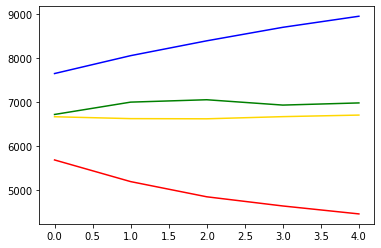

In [6]:
plt.plot(pred_y, color='gold') ## 모델이 예측한 가격 그래프
plt.plot(pred_y_lower, color='red')  ## 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_upper, color='blue')  ## 모델이 예측한 최고 가격 그래프
plt.plot(test_y, color='green')  ## 실제 가격 그래프

이번에는 상한가와 하한가를 제외한 뒤, 그래프를 그려보자. 

그래프의 상승 경향을 살펴보면 그다지 좋지 않은 예측을 한 것으로 보인다. 

하지만 '5일 동안 상승할 것이다'라는 아주 큰 트렌드 정도는 예측할 수 있다.

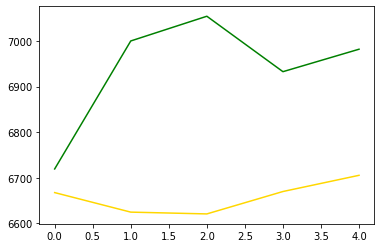

In [7]:
plt.plot(pred_y, color='gold')   ## 모델이 예상한 가격 그래프
plt.plot(test_y, color='green')  ##  실제 가격 그래프

In [8]:
# Test RMSE 측정하기
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

309.0099117445821


이번에는 ARIMA 보다 조금 더 정확한 트렌드 예측 분석을 제공하는 라이브러리 'Facebook Prophet'을 사용해보자. Prophet은 Additive 모델이라는 모델링 방법에 기반한 시계열 예측모델로서 시계열 데이터의 트렌드성(연간/월간/일간)을 예측하는 것에 초점이 맞추어져 있다.


---


*   Additive 모델

: Additive 모델은 선형 회귀 분석의 단점을 극복하기 위해 개량된 분석 방법의 하나이다. 

시계열 분석 역시 회귀 분석의 한 갈래이기 때문에 회귀 분석의 단점을 가지고 있다.

하지만 회귀 분석의 단점을 극복하기 위해 이 모델은 각 피처마다 비선형적 적합을 가능하게 하는 일련의 방법을 적용한다. 

(참고: https://peerj.com/preprints/3190/)



In [9]:
from fbprophet import Prophet

**fbprophet 라이브러리를 사용하기 위해서는 데이터 프레임의 피처를 'ds'와 'y'로 변경해야 한다.**

그리고 Prophet이라는 클래스를 선언한 뒤, fit()함수로 모델을 학습시킨다.

모델 생성에 포함되는 파라미터의 의미는 다음과 같다.


*   **seasonality_mode** : 연간, 월간, 주간, 일간 등의 트렌드성을 반영하는 것을 의미하는 파라미터이다. 
*   **changepoint_prior_scale** : 트렌드가 변경되는 문맥을 반영하는 파라미터이다. 수치가 높을수록 모델은 과적합에 가까워진다.

---

아래 코드는 Facebook Prophet을 활용하여 시계열 모델을 학습하는 코드이다.

### 1.2.2. Facebook Prophet 활용

In [10]:
# Facebook Prophet 활용하기

## prophet을 사용하기 위해서는 다음과 같이 피처명을 변경해야 한다 : 'ds', 'y'
bitcoin_df = pd.read_csv(file_path, names=['ds','y'])

prophet = Prophet(seasonality_mode = 'multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

다음 코드 중 make_future_dataframe(periods=5, freq='d'), prophet.predict(future_data)를 실행하면 학습 데이터셋 기반의 5일 단위 예측 데이터를 얻을 수 있다. 

아래의 실행 결과는 데이터에 존재하지 않은 5일 단위의 미래를 예측한 것이다.

In [11]:
# 5일을 내다보며 예측하기
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)
forecast_data[['ds','yhat','yhat_lower','yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
365,2018-08-27,6870.046369,6189.973317,7538.786932
366,2018-08-28,6958.173352,6317.009616,7680.672650
367,2018-08-29,6966.981989,6203.919914,7612.845489
368,2018-08-30,7028.094432,6286.335121,7759.114052
369,2018-08-31,7101.738804,6314.921579,7843.048838


다음은 fbprophet 모델의 학습 결과를 시각화한 결과이다. 

그래프의 검은 점은 실제 가격을 나타낸 것이고, 파란 선은 예측 가격을 나타낸 것이다.

이 모델 역시 ARIMA 모델과 마찬가지로 학습 데이터셋에 대해서는 거의 정확한 예측을 하고 있다.

하지만 시계열 데이터 분석에서 학습 데이터를 잘 예측하는 것은 큰 의미가 없다.

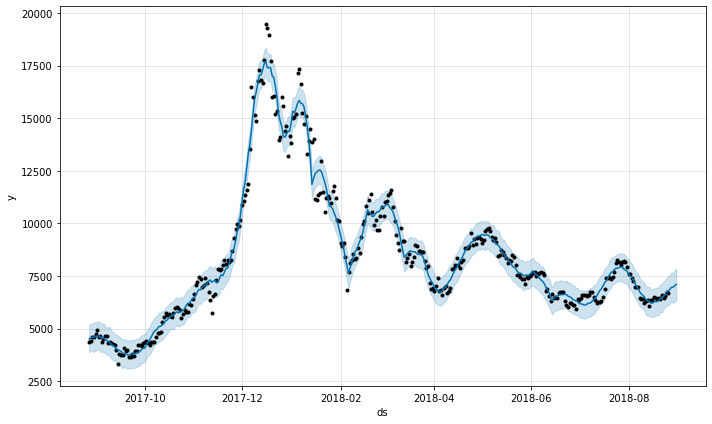

In [12]:
# fbprophet 모델의 학습 결과를 시각화 - 학습 데이터셋 예측
fig1 = prophet.plot(forecast_data)

다음의 그래프는 fbprophet에서 제공하는 트렌드 정보 시각화 그래프이다.

앞서 seasonality_mode 파라미터를 설정해놓은 경우에만 이 시각화가 가능하다.

이를 통해 시계열 데이터가 어떤 흐름을 가지고 변화하는지 살펴볼 수 있다.

전체적인 데이터의 트렌드는 아래의 첫번째 그래프로 살펴볼 수 있고, 이어지는 그래프에서는 year, weekly, daily 순의 트렌드를 확인할 수 있다.

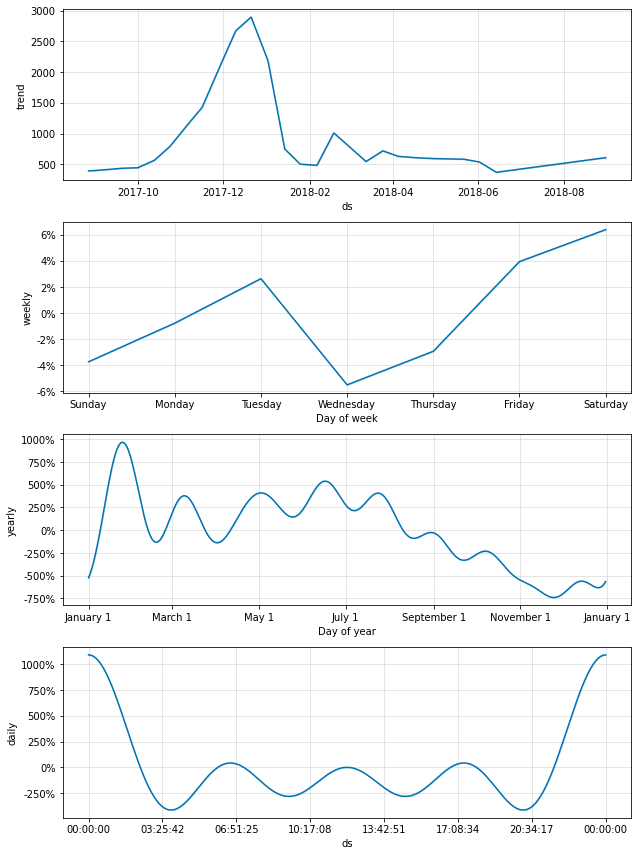

In [13]:
# fbprophet에서 제공하는 트렌드 정보 시각화
fig2 = prophet.plot_components(forecast_data)

ARIMA 모델을 평가한 것과 동일한 방법으로 테스트 데이터셋을 평가해보자.

다음 코드의 실행 결과, ARIMA 모델보다는 prophet 모델이 실제 price 값에 더 근접한 예측을 하는 것처럼 보인다.

이를 RMSE와 함께 더 자세히 살펴보자!

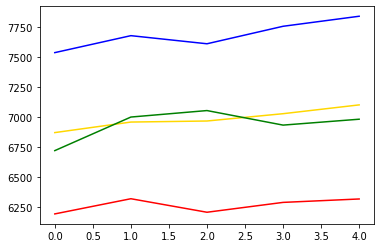

In [14]:
# Facebook Prophet 활용하기: 실제 데이터와의 비교
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds','y'])

## 마지막 5일의 예측 데이터 (2018-08-27 ~ 2018-08-31)
pred_y = forecast_data.yhat.values[-5:]

## 실제 5일 가격 데이터 (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values

## 마지막 5일 예측 데이터의 최소값
pred_y_lower = forecast_data.yhat_lower.values[-5:]

## 마지막 5일 예측 데이터의 최대값
pred_y_upper = forecast_data.yhat_upper.values[-5:]

plt.plot(pred_y, color='gold') ## 모델이 예상한 가격 그래프
plt.plot(pred_y_lower, color='red') ## 모델이 예상한 최저 가격 그래프
plt.plot(pred_y_upper, color='blue') ## 모델이 예상한 최고 가격 그래프
plt.plot(test_y, color='green') ## 실제 가격 그래프

다음으로 이 모델의 Test RMSE를 ARIMA 모델과 비교해보자. ARIMA 모델의 Test RMSE는 309 정도였던 것에 반해 이 모델의 Test RMSE는 101정도로 감소하였다. 

또한 '5일 동안 얼마만큼 상승할 것이다'라는 트렌드를 꽤나 정확하게 예측한 것으로 보인다.



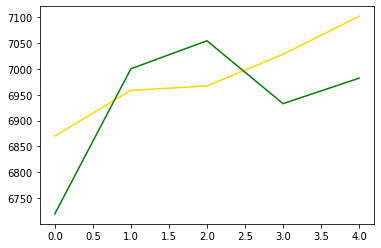

In [15]:
plt.plot(pred_y, color='gold')  ## 모델이 예상한 가격 그래프
plt.plot(test_y, color='green')  ## 실제 가격 그래프

In [16]:
# Test RMSE 측정하기
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

105.41853842279897


## 1.3. 활용 - 더 나은 결과를 위한 방법

이번 분석 단계에서는 모델의 성능을 조금 더 향상시킬 수 있는 방법들에 대해 알아보겠다.

첫 번째로 고려해볼 방법은 **상한값 혹은 하한값을 지정해 주는 것**이다.

바닥과 천장이 없는 주가 데이터의 경우에는 의미가 없을 수 있지만 일반적인 시계열 데이터에서는 상한값 혹은 하한값을 설정해주는 것이 모델의 성능을 높여줄 수 있는 방법 중 하나이다. 

Prophet 모델에서는 future_data['cap'] = 20,000을 통해 데이터셋에 상한선을 설정할 수 있다.

다음 코드와 실행 결과는 상한선을 적용한 학습 결과를 시각화한 것이다.

겉으로 보기에는 원래의 결과와 별 차이가 없어 보인다.

### 1.3.1. 상한가 및 하한가 설정하기

In [17]:
# 상한가 및 하한가 설정하기 
bitcoin_df = pd.read_csv(file_path, names=['ds','y'])

## 상한가 설정하기
bitcoin_df['cap'] = 20000

## 상한가 적용을 위한 파라미터를 다음과 같이 설정한다.
prophet = Prophet(seasonality_mode='multiplicative',
                  growth='logistic',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

In [18]:
# 5일을 내다보며 예측한다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')

# 상한가를 설정한다.
future_data['cap']=20000
forecast_data = prophet.predict(future_data)

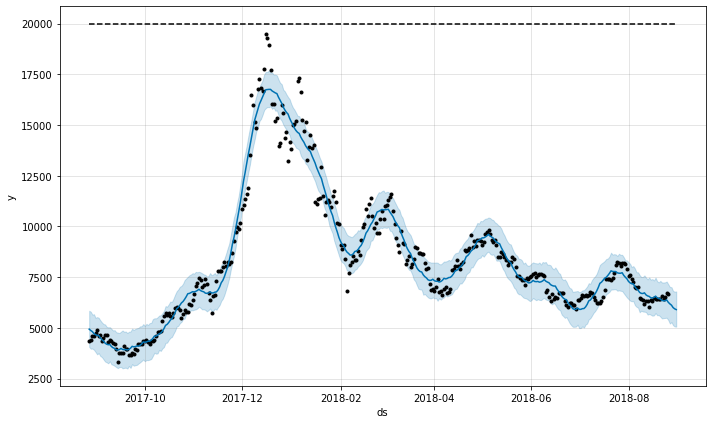

In [19]:
fig = prophet.plot(forecast_data)



---

**실제 데이터와의 비교**

*   비트코인 데이터의 경우, 상한선을 둠으로써 오히려 예측력이 다소 떨어지는 결과를 보인다.




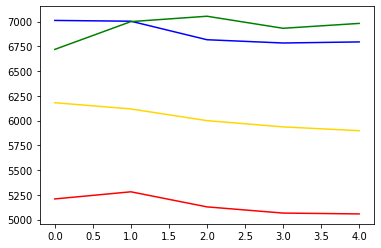

In [20]:
# 예측과 실제 비교 그래프
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds','y'])

# 모델이 예측한 마지막 5일의 가격 데이터를 가져온다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

plt.plot(pred_y, color='gold')  # 모델이 예측한 가격 그래프
plt.plot(pred_y_lower, color='red') # 모델이 예측한 하한가 그래프
plt.plot(pred_y_upper, color='blue')  # 모델이 예측한 상한가 그래프
plt.plot(test_y, color = 'green')  # 실제 가격 그래프

예측 모델이 형편없는 결과를 예측했다는 것을 알 수 있다. 

모델이 예측한 상한가(파란색)보다 실제 가격(녹색)이 더 높기 때문이다.

게다가 이번에는 '5일 동안 상승/하락할 것이다'라는 큰 범위의 트렌드를 예측하는 것조차 실패했다.

상한가라는 개념이 큰 의미가 없는 비트코인 데이터의 경우에는 상한선을 설정한 것이 오히려 독이 되었다고 볼 수 있다.


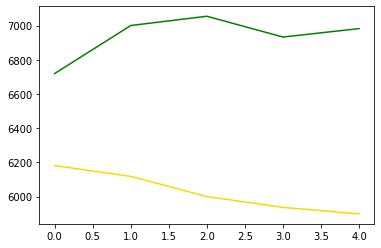

In [21]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프
plt.plot(test_y, color="green") # 실제 가격 그래프

In [22]:
# 테스트 데이터의 RMSE 출력
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

932.3951963564807


### 1.3.2. 이상치 제거하기

이제 모델의 성능을 향상시키는 다른 방법 중 하나인 **이상치 제거 기법**을 살펴보자. 

이상치란 평균적인 수치에 비해 지나치게 높거나 낮은 수치의 데이터를 의미한다. 

이전 예제에서 살펴보았던 상자 그림의 울타리 밖 영역에 있는 데이터들을 이상치 데이터라고 한다.

**fbprophet 모델이 이상치를 제거한 데이터로 학습하려면 이상치에 해당하는 데이터를 None으로 설정해주면 된다.**

다음 코드에서는 **18,000 이상을 이상치라고 설정**하였다. 그리고 나머지 부분은 이전과 동일하게 실행한다.

사실 그래프만 놓고 본다면 이전과 큰 차이가 없어 보인다.

In [23]:
# 18,000 이상의 데이터는 이상치라고 판단한다.
bitcoin_df = pd.read_csv(file_path, names=['ds','y'])
bitcoin_df.loc[bitcoin_df['y'] > 18000, 'y'] = None

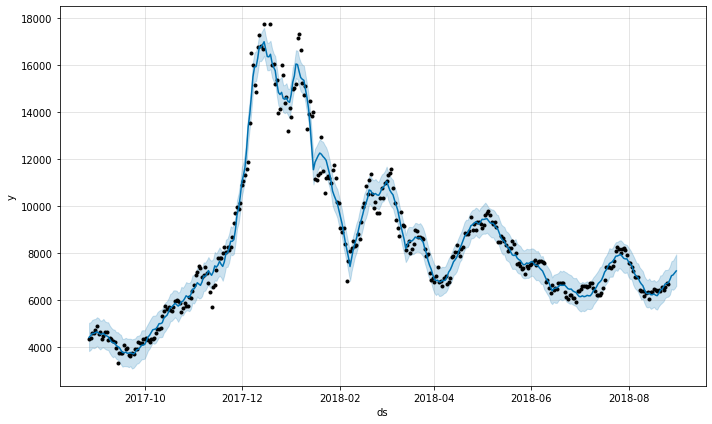

In [24]:
# prophet 모델을 학습한다.
prophet = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)


# 5일 단위의 미래를 예측한다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

# 예측 결과를 그래프로 출력한다.
fig = prophet.plot(forecast_data)

마찬가지 방법으로 예측값과 실제값을 그래프로 나타내보자.


**실제 데이터와의 비교**


*   비트코인 데이터의 경우, 이상치를 제거함으로써 오히려 예측력이 다소 떨어지는 결과를 보였다.
*   모델의 정확도 스코어 측면에서는 떨어졌지만, 트렌드 예측의 측면에서는 다소 나은 모습을 보여줄 수도 있다.

In [25]:
bitcoin_test_df = pd.read_csv(test_file_path, names = ['ds', 'y'])

# 모델이 예상한 마지막 5일의 가격 데이터를 가져온다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

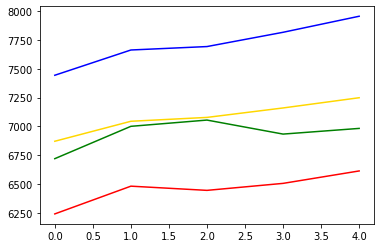

In [26]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프
plt.plot(test_y, color="green") # 실제 가격 그래프

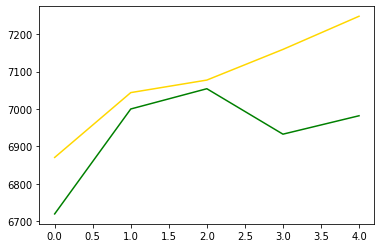

In [27]:
# 예측값과 실제값 비교 시각화
plt.plot(pred_y, color='gold')  ## 모델이 예측한 가격 그래프
plt.plot(test_y, color='green') ##  실제 가격 그래프

In [28]:
# 테스트 데이터의 RMSE 출력
rmse = sqrt(mean_squared_error(pred_y, test_y))
rmse

171.83159828333595

이를 살펴본 결과, 이상치를 제거하는 것이 정확도(RMSE)면에서는 떨어지지만 '트렌드'를 예측하는 측면에서는 이전 모델보다 더 낫다고 볼 수 있다.

## 1.4. 한걸음 더 나아가기

### 1.4.1. ARIMA 모델의 하이퍼 파라미터 선정하기


**적절한 파라미터 선정하기**



*   ARIMA 모델은 p,d,q 세 가지 파라미터를 적절하게 선정하는 것이 가장 중요하다.
*   ACF(Autocorrelation function), PACF(Partial autocorrelation function) 그래프를 통해 대략적인 파라미터를 선정한다.

In [29]:
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price'])
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)

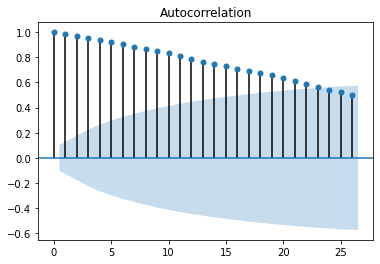

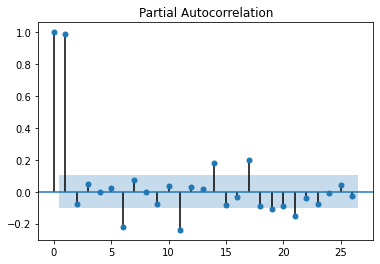

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(bitcoin_df.price.values)
plot_pacf(bitcoin_df.price.values)
plt.show()



---

**ARIMA 모델 학습**

*   그래프를 토대로 1차 학습



In [31]:
model = ARIMA(bitcoin_df.price.values, order=(15,2,0))
model_fit = model.fit(trend='c',full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  363
Model:                ARIMA(15, 2, 0)   Log Likelihood               -2766.312
Method:                       css-mle   S.D. of innovations            491.703
Date:                Wed, 17 Mar 2021   AIC                           5566.625
Time:                        15:33:52   BIC                           5632.830
Sample:                             2   HQIC                          5592.941
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0047      4.347     -0.001      0.999      -8.524       8.515
ar.L1.D2.y     -0.8160      0.052    -15.652      0.000      -0.918      -0.714
ar.L2.D2.y     -0.7860      0.068    -11.633    



*   1차 결과를 토대로 2차 학습


In [32]:
model = ARIMA(bitcoin_df.price.values, order=(2,1,2))
model_fit = model.fit(trend='c',full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2780.074
Method:                       css-mle   S.D. of innovations            501.536
Date:                Wed, 17 Mar 2021   AIC                           5572.148
Time:                        15:34:16   BIC                           5595.531
Sample:                             1   HQIC                          5581.442
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3951     26.944      0.237      0.813     -46.414      59.204
ar.L1.D.y      0.4496      0.029     15.512      0.000       0.393       0.506
ar.L2.D.y     -0.9622      0.023    -42.314      0.0

## 1.5. 재미로 알아보는 내일의 비트코인 시세

좋은 예측력을 보였던 Prophet 모델로 향후 5일간의 비트코인 시세를 예측해 보자!

In [33]:
# prophet을 사용하기 위해서는 다음과 같이 피처의 이름을 변경해야 한다 : 'ds', 'y'
bitcoin_df = pd.read_csv(file_path, names = ['ds', 'y'])
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

In [34]:
# 5일단위의 미래를 예측한다.
future_data = prophet.make_future_dataframe(periods=5, freq = 'd')
forecast_data = prophet.predict(future_data)

In [35]:
# 테스트 데이터를 불러온다.
bitcoin_test_df = pd.read_csv(test_file_path, names = ['ds', 'y'])

# 마지막 5일의 데이터를 가져온다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

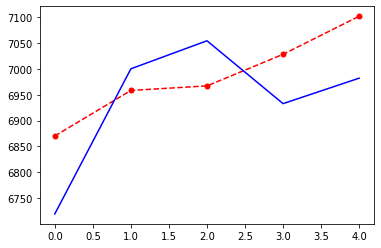

In [36]:
plt.plot(pred_y, color="red", ls="--", marker="o", ms=5) # 모델이 예상한 가격 그래프
plt.plot(test_y, color="blue") # 실제 가격 그래프